# 240 : Qualitative analysis using M2

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #Numéro GPU
print(os.environ["CUDA_VISIBLE_DEVICES"])

2


In [28]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset"
else:
  BASE = Path(os.path.dirname(os.path.realpath("__file__"))).resolve() # If not on GColab, BASE will be the directory of this notebook
  DATASETS = Path('/work/stual/dataset_ICDAR').resolve()
  OUT_BASE = Path('/work/stual/res_ICDAR/method_2').resolve()

print(sys.path)
print(BASE)
print(DATASETS)
print(OUT_BASE)

['/lrde/home2/stual/stage_DAS/m2_joint-labelling_for_ner', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages']
/lrde/home2/stual/stage_DAS/m2_joint-labelling_for_ner
/work/stual/dataset_ICDAR
/work/stual/res_ICDAR/method_2


## Model

Choose a fine-tuned model to evaluate in the following list :

In [45]:
import glob

models_list = sorted(glob.glob(f"{OUT_BASE}/tmp/*/checkpoint*"))
print("FINE-TUNED MODELS")
for m in models_list:
    l = m.split('/')
    l = '/'.join(l[-2:])
    print(l)

FINE-TUNED MODELS
211-camembert-ner-joint-labelling-io/checkpoint-600
212-camembert-ner-joint-labelling-iob2/checkpoint-1300
213-pretrained-camembert-ner-joint-labelling-io-classes/checkpoint-2400
214-pretrained-camembert-ner-joint-labelling-iob2-classes/checkpoint-3100
221-camembert-ner-joint-labelling-io/checkpoint-2000
222-camembert-ner-joint-labelling-iob2/checkpoint-1500
223-pretrained-camembert-ner-joint-labelling-io/checkpoint-1200
224-pretrained-camembert-ner-joint-labelling-iob2/checkpoint-1200


In [46]:
MODEL_PATH = f"{OUT_BASE}/tmp/223-pretrained-camembert-ner-joint-labelling-io/checkpoint-1200"

## Load data

### Gold

In [67]:
import os
from pathlib import Path
from config import logger
from datasets import load_from_disk

TRAINSETS_SIZES = [6084] #To train only on the biggest dataset

# INPUT / OUTPUT DIRS
INPUT_DIR = OUT_BASE / f"m2-experiment_1_prepared_dataset_pero_ocr_io_camembert_ner_v2"
train_dev_test = load_from_disk(INPUT_DIR / "huggingface_6084")
test = train_dev_test["test"]
test[0]

/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


{'tokens': ['▁Au',
  'bert',
  'in',
  ',',
  '▁professeur',
  '▁au',
  '▁lycée',
  '▁Louis',
  '-',
  'le',
  '-',
  'Grand',
  ',',
  '▁Saint',
  's',
  '-',
  'P',
  'ères',
  ',',
  '▁7',
  '.'],
 'ner_tags': ['I-PER+O',
  'I-PER+O',
  'I-PER+O',
  'O+O',
  'I-DESC+i_ACT',
  'I-DESC+O',
  'I-DESC+O',
  'I-DESC+O',
  'I-DESC+O',
  'I-DESC+O',
  'I-DESC+O',
  'I-DESC+O',
  'O+O',
  'I-SPAT+i_LOC',
  'I-SPAT+i_LOC',
  'I-SPAT+i_LOC',
  'I-SPAT+i_LOC',
  'I-SPAT+i_LOC',
  'I-SPAT+O',
  'I-SPAT+i_CARDINAL',
  'O+O'],
 'input_ids': [5,
  277,
  21,
  2872,
  378,
  21,
  7,
  2136,
  36,
  3288,
  2027,
  67,
  16,
  67,
  1224,
  21,
  7,
  377,
  52,
  67,
  275,
  21,
  4487,
  21,
  7,
  333,
  21,
  9,
  6],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  1,
  1,
  -100,
  1,
  0,
  -100,
  5,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  0,
  -100,
  8,
  8

### Non-structured entries

In [68]:
import pandas as pd

PATH = INPUT_DIR / f'test_entries.txt'
with open(PATH, 'r',encoding='utf8') as ex:
    lines = ex.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i].replace('\n','')
print(len(lines))
print(str(PATH))

1685
/work/stual/res_ICDAR/method_2/m2-experiment_1_prepared_dataset_pero_ocr_io_camembert_ner_v2/test_entries.txt


## Use model on entries

In [49]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline

LIMIT = 100

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH) #Param : tokenizer du modele souhaité
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH) #Modèle choisi

#Classification des entités
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy=None, use_fast=True)

In [50]:
from xmlize_util import get_NER_tags
if FORMAT == "IOB2":
    from camembert_utils.util_IOB2 import word_tokens_from_nested_xml_iob2
else:
    from camembert_utils.util_IO import word_tokens_from_nested_xml
from xmlize_util import get_NER_tags, xmlize_multilevel

stats = []
k = 0 
errors_count = 0
errors = []
for i in range(len(lines)):
    print(lines[i])
    res = nlp(lines[i])
    preds_tokens, preds_tags = [],[]

    for e in res:
        preds_tokens.append(e["word"])
        preds_tags.append(e['entity'])
    levels, num_levels = get_NER_tags(lines[i],res,FORMAT)
    xml = xmlize_multilevel(levels,num_levels)

    try:
        assert len(test[i]["tokens"]) == len(preds_tokens)
        assert len(test[i]["ner_tags"]) == len(preds_tags)
        stats.append([k,lines[i],xml,test[i]["tokens"],test[i]["ner_tags"],preds_tokens,preds_tags])
    except:
        errors_count += 1
        print(test[i]["tokens"])
        print(preds_tokens)
        print("NUM " + str(k))
        print(lines[i][:-1])
    k += 1
    
#print(errors_count)

Aubertin, professeur au lycée Louis-le-Grand, Saints-Pères, 7.
baints-Peres, . Aubertin, représentant du peuple (Marne), Richelieu, 63.
Aubertin, teinturier - dégraisseur, passage Brady, 30, 32 et 34, et Cadet, 6.
Aubertin, teinturier-dégraisseur, Faub.-St- Honoré, 99.
Auberville (Ctesse douairière d&apos;), Grenelle-St- Germ., 69.
Auberville (Ctesse d&apos;) , Grenelle-Saint-Ger- main, 100.
Aubery-Fromental, bijout. en or, Temple, 89.
Aubery-Galban, imp.-lithog. pass. du Caire, 129.
Aubespin (Cte Léonel de l), Union, 24.
Aubeux, fab d&apos;étoffes pour gilets, Orillon, 20, et impasse de l&apos;Orillon, 6.
Aubier, épicier, place Saint-Sulpice, 6, et Ca- nettes, 25.
Aubigny d&apos;Assy (Ctesse d), Babylone, 24.
Aubin, artificier, Lafayette, 113, en face la rue Château-Landon.
Aubin, avoc. à la cour de cassation, Joubert, 6.
Aubin, boulanger, Petits-Augustins, 20.
Aubin (Ch.), commissionn., Faubourg-Pois- sonnière, 8.
Aubin, cuirs en poils, Française, 4.
Aubin et Cie éperonn., St-Nicolas

Audin, homme de lettres, Christine, 3.
Audin, maréchal-expert, Laborde, 43.
Audinet, offic. de santé, Deux-Ecus, 33.
Audinet et Cie, vins en gros, quai de la Tour- nelle, 33.
Audiquet, bijoutier en doré et metteur en œu- vre, Temple, 83.*)
Audoin, tailleur, Geoffroy-Marie, 12.
Audoire, pâtissier, St-Honore, 107.
Audois (Vve), fabr. de franges pour châles, Montorgueil, 71.
Audon ainé, négociant, Poissonnière, 37.
Audot, libraire, Paon-St-André, 8.
Audot, plaqué, nécessaires, orfévrerie, Riche- lieu, 81.
Audot (Mme), sage-femme, Faubourg-Saint- Jacques, 6.
Audouard, courtier de comm., rue...
Audouard fils, graveur en bijoux, Grenelle-St- Honore, 19.
Audouard (P. et L.), fab. de joaillerie, bijou- terie, Grenelle-St-Honoré, 19.
Audouard, O. X, médecin, Cadet, 6.
Audoucet (Mme), lingerie et nouveautés, Mont- martre, 104.
Audouin, ancien avoué, Bourbon-Villeneuve,33.
Audouin ( A.), graisse pour voitures, Vieilles-Haudriettes, 8.
Audouin (L.), commissionnaire en papeterie, Petit-Lion-St-Sauv

Daudet (Eug.), institution, f. St-Honoré, 235.
Daudet et Loisel, maçons, St-Nicolas d&apos;Antin, . 4
Daudeville, potier d&apos;étain, Cimetière-St-Nico- las, 19.
Daudin, fab. de chapeaux, Vieille-du-Temple, 8.
Daudin, faïencier, q. de la Mégisserie, 56, et St-Germain-lAuxerrois, 65.
Daudin, hôtel de Strasbourg, Fidelite, 17.
Daudin, libraire, St-Victor, 63
Daudre (F.) et Ch. Rattaire, negoc., Mont- martre. 169.
Dandre (A.), mousseline et linge de table en gros, Bertin-Poirée, 17.
Daudy, libraire, passage St-Roch, 10.
Dauge, brosserie, St-Martin, 166.
Dauge (P.), dépòt de papiers, Blancs-Man- teaux. 35.
Dauge (F.) fils et Cie, filateurs de coton et fabri- cants de cotons retors, St-Fiacre, 3.
Daugny (B.) §, rentier, Bleue, 29.
Daugreilh, salon littéraire, Faub.-St-Hono- ré, 66.
Daulé, stéréotypeur,St-Benoit-St-Germain, 8.
Daulle, C. s, général, boulev. Poisson- nière. 23.
Daumain, bijoutier-garniss., Phélippeaux, 22.
Daumas (T.), fabricant d&apos;encre d&apos;imprimerie et produits chi

Gautrin, épicier, Faub.-St-Antoine, 207.
Gautrin, maraicher, St-Maur-Popincourt, 224.
Gautrin (F.), serrurier en bâtiments, Argen- teuil, 37.
Gautron, dit Grassot, boulanger, Orléans-St- Marcel, 23.
Gautron, coiffeur, Savonnerie, 1.
Gautron, mécanicien, Grenétat, 16.
Gautron dit Grassot (Mme), modes, Orléans- St-Marcel, 25.
Gautron, vermicelle, Grande Tuanderie, 15.
Gautrot (P. J.). administrateur général du Mandataire des contribuables, Drouot, 1 et 3.
Gautrot ainé et Cie, fab. d&apos;instruments de mu- sique, St-Louis-Marais, 60.
Gautrot et Foubert, fab. de bronzes, Saint- Louis-Marais, 65.
Gautruche, vins, Quincampoix, 23 et 26.
Gautry, gants, Rivoli, 28 bis.
Gauvain, arquebusier, tient tir, boul. Mont- Parnasse, 93.
Gauvain, chaussures pour dames, Faub.-St- Denis, 35.
Gauvain (Mme libraire, St-Antoine, 177,
Gauvin, objets d&apos;arts en plâtre, passage des Panoramas, galerie des Variétés, 5.
Gauvin, ebeniste, Suresne, 8.
Gauvin, lapidaire et bombeur de verres, Trans- nonain, 40.
Ga

Vaugeois (Mlles), broderies, St-Honoré, 371.
Vaugeois et Truchy, passementeries et bro- deries, Mauconseil, 1, en face le corps de garde.*)
Vaugeois, maçon, Angoulême-du-Temple,50.
Vaugeois, vins, Coq-St-Honore, 11.
Vaugien, appartements meublés, avenue Ste- Marie-du-Roule, 6.
Vaugiraud (Vte de), St-Dominique-St-Ger- main, 41.
Vaugon, boucher, St-Louis-St-Honoré, 9, et St-Honore, 273.
Vaugon, fab. de cols-crav., Rambuteau, 57.
Vaugondy fab. de chaussons de tresse, St-An- toine, 128.
Vaugoux, fleurs, Caire, 2.
Vaugrenat (de), Casimir--Périer, 6.
Vaujuas (de), représentant du peuple (Ma- venne) Grenelle-St-Germain, 75.
Vaulabelle, conservat. du cimetière du Nord (Montmartre).
Vaulabelle (de h. de lettres, Lamartine, 34.
Vaulogé (Vte */ et Vsse Cherche-Midi, 11.
Vaulot, potier d&apos;étain, fab. de comptoirs de marchands de vins, St-Martin, 220čis.
Vaumier (Vre), faiences, marché à la Verdure, 60.
Vaumorin,tonnelier, Grenelle-St-Germ., 84.
Vaunois, anc. avoué, Louis-le-Grand, 35.
Vauqueli

Vigier jeune, commiss. en horlog., Bouloi, 10.
Vigier, coutelier, Faub.-St-Antoine, 247.
Vigier (Cte A.), � 2, quai Voltaire. 1.
Vigier (S. et J.) frères, fab. de tapis, Crois- sant, 18.
Vigier, plumassier, Mazagran, 13.
Vigla, bijoutier pour deuil, Gravilliers 1.
Vigla �§, médecin, Vieux-Colombier, 3.
Vignacourt comtesse de Bac, 94.
Vignais, mécanicien -serrurier, Nve-St-Lau- rent, 10.
Vignais (de), orfévrer. plaq., Montmartre, 180.
Vignal, médecin, Faub.-St-Denis, 50.
Vignat frères, rubans et étoffes de soie, place des Victoires, 3.
Vignau, coiffeur, St-Victor, 165.
Vignaud (J.) et Cie , mérinos et impressions, Sentier, 6.
Vignaud, restaurateur, place de l&apos;Odéon, 2, et carrefour. 38.
Vignaux, pâtissier, Dauphine, 10.
Vigné, outils et ferrailles, Beaubourg, 50.
Vigne, bois en gros et détail, Union, 20.
Vigne jeune, jouets d&apos;enfants, Beaubourg, 59.
Vigneaux, bur. de placement des garçons mar- chands de vins, q. de la Grève, 24.
Vignères, marchand d&apos;écriteaux, Ste-Anne, 1

Gérard et Courtois, (D 1849, q de la Megisserie, 34.
Germain, Amandiers-Popinc., 32, et St-Maur-Popincourt. 5.
Gros, St-Maur-Popincourt, 228.
Hacville fils, Loursine, 141
Hervé, Fourneaux. 39
Heurteaux, Charonne, 130, faub.
Houdart, Montreuil, 82.
Huard, Loursine, 74.
Jacquin aîné et Cie, gramiers, fleuristes et pépiniéristes; com- merce en gros et en détail de graines potagères et fourragè- res, graines de fleurs et d&apos;ar- bres, oignons à fleurs et plantes et arbres de tous genres ; au Bon Jardinier, quai de la Mégisse- rie, 14. Cultures expérimentales, au Grand-Charonne, route de Bagnolet, 20, près Paris; mé- dailles d&apos;or et d&apos;argent des di- verses societés horticoles.
Jamain (H.), Cendrier, 1.
Jamin (J.-L.) et Durand, Buffon, 69, près le Jardin des Plantes. Pepinières générales et siége de l&apos;établissement à Bourg-la-Reine, près Sceaux, (B 1849.
Jolly (P.), des sinateur de jardins, Petit-Pont, 10.
Jourdier, Charenton, 115.
Laine, Muette, 10.
Lamy, Genti ly, 36.
Lap

Basserie et Cie. Roquette, 188.
Benard, Pot-de-Fer-St-Marcel, 4.
Bernard, Enfer, 124
Beuvrier, graveur, Roquette S
Blot frères, Roquette, 184.
Boiteux, Francs-Bourgeois -Ma- rais, 0.
Boiton dit Latonr, sculpteur-mar- brier, Roquette, 111.
Bolard, Nve-Coquenard, 13 bis.
Bordes, Roquette, 163.
Boucneau jeune, Amelot, 76.
Bouguet, St-Denis, 380.
Bourgès, Roquette, 153.
Bourrousse fils aîné, fab. de fon- taines filtrantes en pierre et en marbre, fait la fourniture de toutes sortes de pierres taillées, tant pour le bâtiment que pour travaux hydrauliques ; fait éga- lement la marbrerie, tant pour meubles et bâtiments que pour monuments funèbres. Fait tou— tes sortes de carrelages en liais et en marbres , mosaïques, dal- lages, etc.; fontaines en gros, en pierre et en marbre, commis- sion en marbrerie, Ste-Avoye, 59, hôtel St-Aignan.
Brasseur, Perle, 4
Brasseur, Petite St-Pierre-Popin- court, 8, ruelle des Lilas, 10.
Bray, Mont-Parnasse, 41.
Brizard, sculpteur-marbrier, Ro- quette, 170.
Bruna

Bounherant, (marchand de thé ef fonl ce qui concerne les dereunema A. Vivienne , 7. 1.
Boucher frères, R. (du Faub. Monx 5. 3 martre, 25. 8
Boncher, R. de Ia Harpe ☞
Bordin, R.S. Denis, 175
n Bordet, n R. Pilliers-Potiers-d&apos;Etain. J4
Bordeau, R. de Gláry,29
Honnin R. S. Martin, 153.
Bonnegn, R. N. des Petits-Champs, 6o.
Bonnard, K. dOrleans,11. H.Ut.H
Boix, R. de. H Concorde ; 12.
— Boisgard, E. Montorguctl, to.
Bobin , R. de la Cossonnerie, At.
Bobin , R. Montorgapil, 33.
Blon elu-du-Rosne, R. du P. Carr. 8.
Blond, (drog.) R. Ste. Marguerite.3o.
Blin R.S. Denis, 210.
Bisbón, R. S. Fictôr 66.
DIÉSOR * R. S. André-des-Aris * — — *
Leek R. du Four, 16. — DHilé.
MP R. . Germain-l Aunerroj4 12.
Detanapí fils. K. du Temple, 4r.
Bouzevíilé K. S Honore 8h-
Apk R. de. Vaugirard, 6r.
ek R. Chabannais, 10.
PČSSkU D1le.) H, des Bourdonnais, 2l-
PK eard, R. Monffetard, 1.
ny — Noirot (aarnden), R. S. Victor,154
Ostat, K. du Bacq *38.
— Rachard,  Birgére, 22
Paneto, R.S. Honpre, 179.
ascal fil

Lange, rue Sainte-Avoie, 19.
Lebel, fabric. de flambeaux et éperons d&apos;or et d&apos;argent, rue Bourg-l&apos;Abbé, 32.
Ledure, ſabr. de bronzes et pendules, rue Neuve des-Petits-Champs, au coin de celle Chabanais.
Lemaire, ſabr. de pendules, candelabres, corbeilles et vases, rue Turenne, 53.
Lemire, rue de la Vieille-Monnaie, 17.
Reiche, et dorures pour les boîtes de pen- dules, r. Notre-Dame-de-Nazareth, 19.
Rigault, fabr., r. du Fanb.-du-Temple,46.
Romain, fabr. pour pendules et girand., r. des Douze-Portes, 3.
Savart, ſabr. de bronzes, tient en pendules assortiment de jolis modèles, r. Phe- lippeaux, 11.
Simon, (Isaac) et fabr. de pendules, rue Neuve-Saint-Merry, 81.
Sornet, (Laurent) fabric. de bronzes, rue de la Ferronnerie, 6.
Soyez, fabr., lient magasin de dorures et lustres. r. N.-des-Pet.-Champs, 89.
Lepage et comp., dorures et articles d&apos;a- meublement, rue Meslay, 58.
Thomire, Duterme et comp., fabric. de bronzes dorés, r. Boucherai, 7.
Tremet, ſabr. r. S.-Denis, 349

Tourzel , rue de Lille , 84.
Tousselot, Marche des Jacobins.
Toutau, rue Richer &quot; 22.
Touzard (le général de), rue de Bour- gogne, 36.
Travault, rue de la Michodiére, Z.
Travenet (Mad. de), rue du Faub.-Saint- Honoré &quot;5.
Tremauville , rue de Grenelle-Faub.-St.- Germain, 45.
Tremignon, rue de la Concorde, 4.
Tremouille (de la) , rue de Lille, 92.
Treneuil (de), bibliothécaire de la biblio- théque de l&apos;arsenal, rue Sully.
Tressan (Mad. de), boulevart des Ita- liens, 20.
Trévise (S. E. le maréchal duc de) , rue de Lille , 88.
Trimolet (Mad.), rue Richelien, 96.
Trion de Montalembert (le comte), membre du corps législatif. rue de la Chaise, 1.
Trollier Fétan, rue Poultière, 14.
Truguet (M. le vice-amiral), rue Verte, 20.
Tuffet Saint-Martin, rue Jacob, 20.
Turenne (de), rue Chauchat, 1.
Turenne (Mad. de), rue Menars, 2.
Turet, quai de l&apos;Ecole, 16.
Turgot , rue Saint-Lazare, 58.
Turpin, de Crissé (le baron), rue du Faub.-Montmartre , 51.
Turreau (le général baron), rue d

In [51]:
len(stats)

1685

In [52]:
columns = ["index","entry","entry_xml","spans_gold","tags_gold","spans_preds","tags_preds"]
df = pd.DataFrame(stats,columns=columns)
df

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds
0,0,"Aubertin, professeur au lycée Louis-le-Grand, ...","<PER>Aubertin</PER><DESC><ACT>, professeur</AC...","[▁Au, bert, in, ,, ▁professeur, ▁au, ▁lycée, ▁...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-DESC+i_ACT,...","[▁Au, bert, in, ,, ▁professeur, ▁au, ▁lycée, ▁...","[I-PER+O, I-PER+O, I-PER+O, I-DESC+i_ACT, I-DE..."
1,1,"baints-Peres, . Aubertin, représentant du peup...","<PER>baints-Peres, </PER><DESC>. Aubertin, rep...","[▁bain, ts, -, Per, es, ,, ▁, ., ▁Au, bert, in...","[O+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PE...","[▁bain, ts, -, Per, es, ,, ▁, ., ▁Au, bert, in...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ..."
2,2,"Aubertin, teinturier - dégraisseur, passage Br...","<PER>Aubertin</PER><ACT>, teinturier - dégrais...","[▁Au, bert, in, ,, ▁teint, urier, ▁-, ▁dég, ra...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-ACT+O, I-AC...","[▁Au, bert, in, ,, ▁teint, urier, ▁-, ▁dég, ra...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ..."
3,3,"Aubertin, teinturier-dégraisseur, Faub.-St- Ho...","<PER>Aubertin</PER><ACT>, teinturier-dégraisse...","[▁Au, bert, in, ,, ▁teint, urier, -, dé, gra, ...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-ACT+O, I-AC...","[▁Au, bert, in, ,, ▁teint, urier, -, dé, gra, ...","[I-PER+O, I-PER+O, I-PER+O, I-ACT+O, I-ACT+O, ..."
4,4,"Auberville (Ctesse douairière d&apos;), Grenel...",<PER>Auberville (Ctesse douairière d&amp;apos;...,"[▁Au, ber, ville, ▁(, C, t, esse, ▁d, ou, ai, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Au, ber, ville, ▁(, C, t, esse, ▁d, ou, ai, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ..."
...,...,...,...,...,...,...,...
1680,1680,"Van-Berchem, rue Bergère, 14.","<PER>Van-Berchem</PER>,<SPAT><LOC> rue Bergère...","[▁Van, -, B, er, che, m, ,, ▁rue, ▁Berg, ère, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Van, -, B, er, che, m, ,, ▁rue, ▁Berg, ère, ...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ..."
1681,1681,"Vandamme, comte d&apos;Unsebourg, rue du Mont-...","<PER>Vandamme</PER><DESC>, comte d&amp;apos;Un...","[▁Vand, am, me, ,, ▁comte, ▁d, &, apos, ;, Un,...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Vand, am, me, ,, ▁comte, ▁d, &, apos, ;, Un,...","[I-PER+O, I-PER+O, I-PER+O, I-DESC+O, I-DESC+O..."
1682,1682,"Toniges, rue Napoléon, 10.","<PER>Toniges</PER>,<SPAT><LOC> rue Napoléon</L...","[▁Ton, ige, s, ,, ▁rue, ▁Napoléon, ,, ▁10, .]","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,...","[▁Ton, ige, s, ,, ▁rue, ▁Napoléon, ,, ▁10, .]","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,..."
1683,1683,"Torcy (de) , rue de Bourgogne, 34.","<PER>Torcy (de)</PER> ,<SPAT><LOC> rue de Bour...","[▁Tor, cy, ▁(, de, ), ▁, ,, ▁rue, ▁de, ▁Bourgo...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Tor, cy, ▁(, de, ), ▁, ,, ▁rue, ▁de, ▁Bourgo...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ..."


## F1-Score ranking
F1-Score is calculated for each entry using seqeval library :
* entities are rebuild using joint-labels with seqeval lib
* f1-score is calculted for each entry

In [53]:
from seqeval.metrics import f1_score

scores = []
count = 0
for i in range(len(df)):
    y_preds = df.iloc[i]["tags_preds"]
    y_true = df.iloc[i]["tags_gold"]
    try:
        f1 = f1_score([y_true],[y_preds])
        scores.append(f1)
    except:
        count += 1
        print(df.iloc[i])
print(count)

/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0


In [54]:
df["f1"] = scores
df = df.sort_values(by=['f1']).reset_index()
del df["level_0"]

In [55]:
df

,index,entry,entry_xml,spans_gold,tags_gold,spans_preds,tags_preds,f1
0,1295,MP R. . Germain-l Aunerroj4 12.,<PER>MP R.</PER><SPAT><LOC> . Germain-l Aunerr...,"[▁MP, ▁R, ., ▁, ., ▁Germain, -, l, ▁A, une, rr...","[I-PER+O, I-SPAT+i_LOC, I-SPAT+i_LOC, I-SPAT+i...","[▁MP, ▁R, ., ▁, ., ▁Germain, -, l, ▁A, une, rr...","[I-PER+O, I-PER+O, I-PER+O, I-SPAT+i_LOC, I-SP...",0.0
1,1251,HertaRK H. de Lappe,<PER>Herta</PER><SPAT><LOC>RK H. de Lappe</LO...,"[▁Her, ta, R, K, ▁H, ., ▁de, ▁La, ppe]","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-SPAT+i_...","[▁Her, ta, R, K, ▁H, ., ▁de, ▁La, ppe]","[I-PER+O, I-PER+O, I-SPAT+i_LOC, I-SPAT+i_LOC,...",0.0
2,1254,"Rennit &quot;et Pignard, RiN. Eganterdí.",<PER>Rennit<TITREH> &amp;</TITREH></PER>quot;<...,"[▁Ren, nit, ▁&, quot, ;, et, ▁Pig, nard, ,, ▁R...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Ren, nit, ▁&, quot, ;, et, ▁Pig, nard, ,, ▁R...","[I-PER+O, I-PER+O, I-PER+i_TITREH, O+O, O+O, I...",0.0
3,1349,"FiRion (H, pla ce des compl Victoires gétoff es","<PER>FiRion (H,</PER><ACT> pla ce</ACT><SPAT><...","[▁Fi, R, ion, ▁(, H, ,, ▁pla, ▁ce, ▁des, ▁comp...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Fi, R, ion, ▁(, H, ,, ▁pla, ▁ce, ▁des, ▁comp...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...",0.0
4,1656,"Treneuil (de), bibliothécaire de la biblio- th...","<PER>Treneuil (de),</PER><DESC><ACT> bibliothé...","[▁Tr, en, euil, ▁(, de, ),, ▁bibliothécaire, ▁...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...","[▁Tr, en, euil, ▁(, de, ),, ▁bibliothécaire, ▁...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, I-PER+O, ...",0.0
...,...,...,...,...,...,...,...,...
1680,1132,"Dubois-Vital,Petite-Rue-St-Pierre- Popincourt,...","<PER>Dubois-Vital</PER>,<SPAT><LOC>Petite-Rue-...","[▁Dubois, -, Vi, tal, ,, Petit, e, -, Ru, e, -...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, O+O, I-SP...","[▁Dubois, -, Vi, tal, ,, Petit, e, -, Ru, e, -...","[I-PER+O, I-PER+O, I-PER+O, I-PER+O, O+O, I-SP...",1.0
1681,1452,"Jiou, rue de la Barillerie, 8.","<PER>Jiou</PER>,<SPAT><LOC> rue de la Bariller...","[▁J, i, ou, ,, ▁rue, ▁de, ▁la, ▁Bar, il, lerie...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,...","[▁J, i, ou, ,, ▁rue, ▁de, ▁la, ▁Bar, il, lerie...","[I-PER+O, I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC,...",1.0
1682,1451,"Huet, rue de la Vieille-Bouclerie, 23.","<PER>Huet</PER>,<SPAT><LOC> rue de la Vieille-...","[▁Hu, et, ,, ▁rue, ▁de, ▁la, ▁Vieille, -, Bou,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...","[▁Hu, et, ,, ▁rue, ▁de, ▁la, ▁Vieille, -, Bou,...","[I-PER+O, I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i...",1.0
1683,1449,"Vallée, rue Saint-Denis, 374.","<PER>Vallée</PER>,<SPAT><LOC> rue Saint-Denis<...","[▁Vallée, ,, ▁rue, ▁Saint, -, Denis, ,, ▁3, 74...","[I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i_LOC, I-S...","[▁Vallée, ,, ▁rue, ▁Saint, -, Denis, ,, ▁3, 74...","[I-PER+O, O+O, I-SPAT+i_LOC, I-SPAT+i_LOC, I-S...",1.0


Text(0.5, 0.98, 'Entery-scale F1-Score distribution over test set')

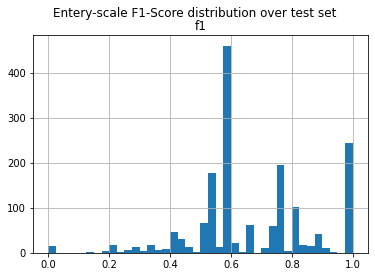

In [56]:
import pylab as pl

df.hist(column='f1',bins=40,sharey=True, sharex=True)
pl.suptitle('Entery-scale F1-Score distribution over test set')

### 15-Top worst

In [57]:
for i in range(0,16):
    print(f"INDEX {i}")
    print(df.iloc[i]["entry"])
    print(df.iloc[i]["entry_xml"])
    print(f"F1-Score : {df.iloc[i]['f1']}")
    print("")

INDEX 0
MP R. . Germain-l Aunerroj4 12.
<PER>MP R.</PER><SPAT><LOC> . Germain-l Aunerroj</LOC><CARDINAL>4 12</CARDINAL></SPAT>.
F1-Score : 0.0

INDEX 1
HertaRK  H. de Lappe
<PER>Herta</PER><SPAT><LOC>RK  H. de Lappe</LOC></SPAT>
F1-Score : 0.0

INDEX 2
Rennit &quot;et Pignard, RiN. Eganterdí.
<PER>Rennit<TITREH> &amp;</TITREH></PER>quot;<PER>et Pignard</PER><SPAT><LOC>, RiN. Eganterd</LOC></SPAT>í.
F1-Score : 0.0

INDEX 3
FiRion (H, pla ce des  compl Victoires  gétoff es
<PER>FiRion (H,</PER><ACT> pla ce</ACT><SPAT><LOC> des  compl Victoires  gétoff es</LOC></SPAT>
F1-Score : 0.0

INDEX 4
Treneuil (de), bibliothécaire de la biblio- théque de l&apos;arsenal, rue Sully.
<PER>Treneuil (de),</PER><DESC><ACT> bibliothécaire</ACT> de la biblio- théque de l&amp;apos;</DESC><SPAT><FT>arsenal</FT><LOC>, rue Sully</LOC></SPAT><DESC>.</DESC>
F1-Score : 0.0

INDEX 5
☞2 Duhamel, Bnufousa et comp. Rue S.  Dentiš ráh =
☞2<PER> Duhamel</PER><DESC>, B</DESC><PER>nufous</PER><DESC>a et comp.</DESC><SPAT

### 15-Top best

In [58]:
rdf = df.sort_values(by='f1', ascending=False)
for i in range(0,16):
    print(rdf.iloc[i]["entry"])
    print(rdf.iloc[i]["entry_xml"])
    print(f"F1-Score : {rdf.iloc[i]['f1']}")
    print("")

Torras, ruę Budaux, 11.
<PER>Torras</PER>,<SPAT><LOC> ruę Budaux</LOC>,<CARDINAL> 11</CARDINAL></SPAT>.
F1-Score : 1.0

Dufoy jeune, Amandiers-Popin- court, 35.
<PER>Dufoy jeune</PER>,<SPAT><LOC> Amandiers-Popin- court</LOC>,<CARDINAL> 35</CARDINAL></SPAT>.
F1-Score : 1.0

Thevenard (le comte de) , sénateur, rue Duphot, 8.
<PER>Thevenard (le comte de)</PER> ,<ACT> sénateur</ACT>,<SPAT><LOC> rue Duphot</LOC>,<CARDINAL> 8</CARDINAL></SPAT>.
F1-Score : 1.0

Dubnis. N -D.-des-Champs, 15.
<PER>Dubnis</PER>.<SPAT><LOC> N -D.-des-Champs</LOC>,<CARDINAL> 15</CARDINAL></SPAT>.
F1-Score : 1.0

Thevenin fils, rue de Lille , 21.
<PER>Thevenin fils</PER>,<SPAT><LOC> rue de Lille</LOC> ,<CARDINAL> 21</CARDINAL></SPAT>.
F1-Score : 1.0

Thiébaut, rue des Trois-Frères, 13.
<PER>Thiébaut</PER>,<SPAT><LOC> rue des Trois-Frères</LOC>,<CARDINAL> 13</CARDINAL></SPAT>.
F1-Score : 1.0

Thalouet, rue Joubert, 20.
<PER>Thalouet</PER>,<SPAT><LOC> rue Joubert</LOC>,<CARDINAL> 20</CARDINAL></SPAT>.
F1-Score : 1.0


## Sub-word global analysis

In [59]:
flat_preds = []
flat_labels = []
for i in range(len(df)):
    flat_preds += df["tags_preds"][i]
    flat_labels += df["tags_gold"][i]
flat_preds = pd.Series(flat_preds, name="Predictions")
flat_labels = pd.Series(flat_labels, name="Gold")

global_confusion = pd.crosstab(flat_labels, flat_preds,normalize='index').multiply(100., axis=1)
global_confusion.columns = ["ACT+O","DESC+O","DESC+ACT","DESC+TITREP","PER+O","PER+TITREH","SPAT+O","SPAT+CARDINAL","SPAT+FT","SPAT+LOC","O+O"]
global_confusion.index = ["ACT+O","DESC+O","DESC+ACT","DESC+TITREP","PER+O","PER+TITREH","SPAT+O","SPAT+CARDINAL","SPAT+FT","SPAT+LOC","O+O"]
global_confusion

,ACT+O,DESC+O,DESC+ACT,DESC+TITREP,PER+O,PER+TITREH,SPAT+O,SPAT+CARDINAL,SPAT+FT,SPAT+LOC,O+O
ACT+O,86.967768,6.904099,3.979308,0.000000,1.074413,0.000000,0.000000,0.000000,0.059690,0.616793,0.397931
DESC+O,7.338129,54.820144,34.604317,0.503597,0.791367,0.000000,0.000000,0.000000,0.000000,1.294964,0.647482
DESC+ACT,4.893617,17.659574,76.808511,0.000000,0.212766,0.000000,0.000000,0.000000,0.000000,0.000000,0.425532
DESC+TITREP,0.000000,50.000000,1.219512,47.560976,0.813008,0.000000,0.000000,0.000000,0.000000,0.000000,0.406504
PER+O,0.376432,0.507365,0.000000,0.000000,98.150573,0.032733,0.000000,0.032733,0.000000,0.441899,0.458265
PER+TITREH,0.000000,0.000000,0.000000,0.000000,4.545455,69.318182,0.000000,0.000000,0.000000,0.000000,26.136364
SPAT+O,0.053677,0.536769,0.000000,0.107354,0.000000,0.000000,93.934514,1.449275,0.053677,3.381643,0.483092
SPAT+CARDINAL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.268528,98.066595,0.000000,0.805585,0.859291
SPAT+FT,12.244898,10.204082,22.448980,0.000000,0.000000,0.000000,4.081633,4.081633,38.775510,4.081633,4.081633
SPAT+LOC,0.088048,0.363196,0.000000,0.000000,0.198107,0.000000,0.286155,0.055030,0.000000,98.822364,0.187101


Confusion matrix of reference and predicted tokens types.
Values are normalized by row (percentage of each reference classe and its resultants predictions)
Last row represent percentage of each class in gold.


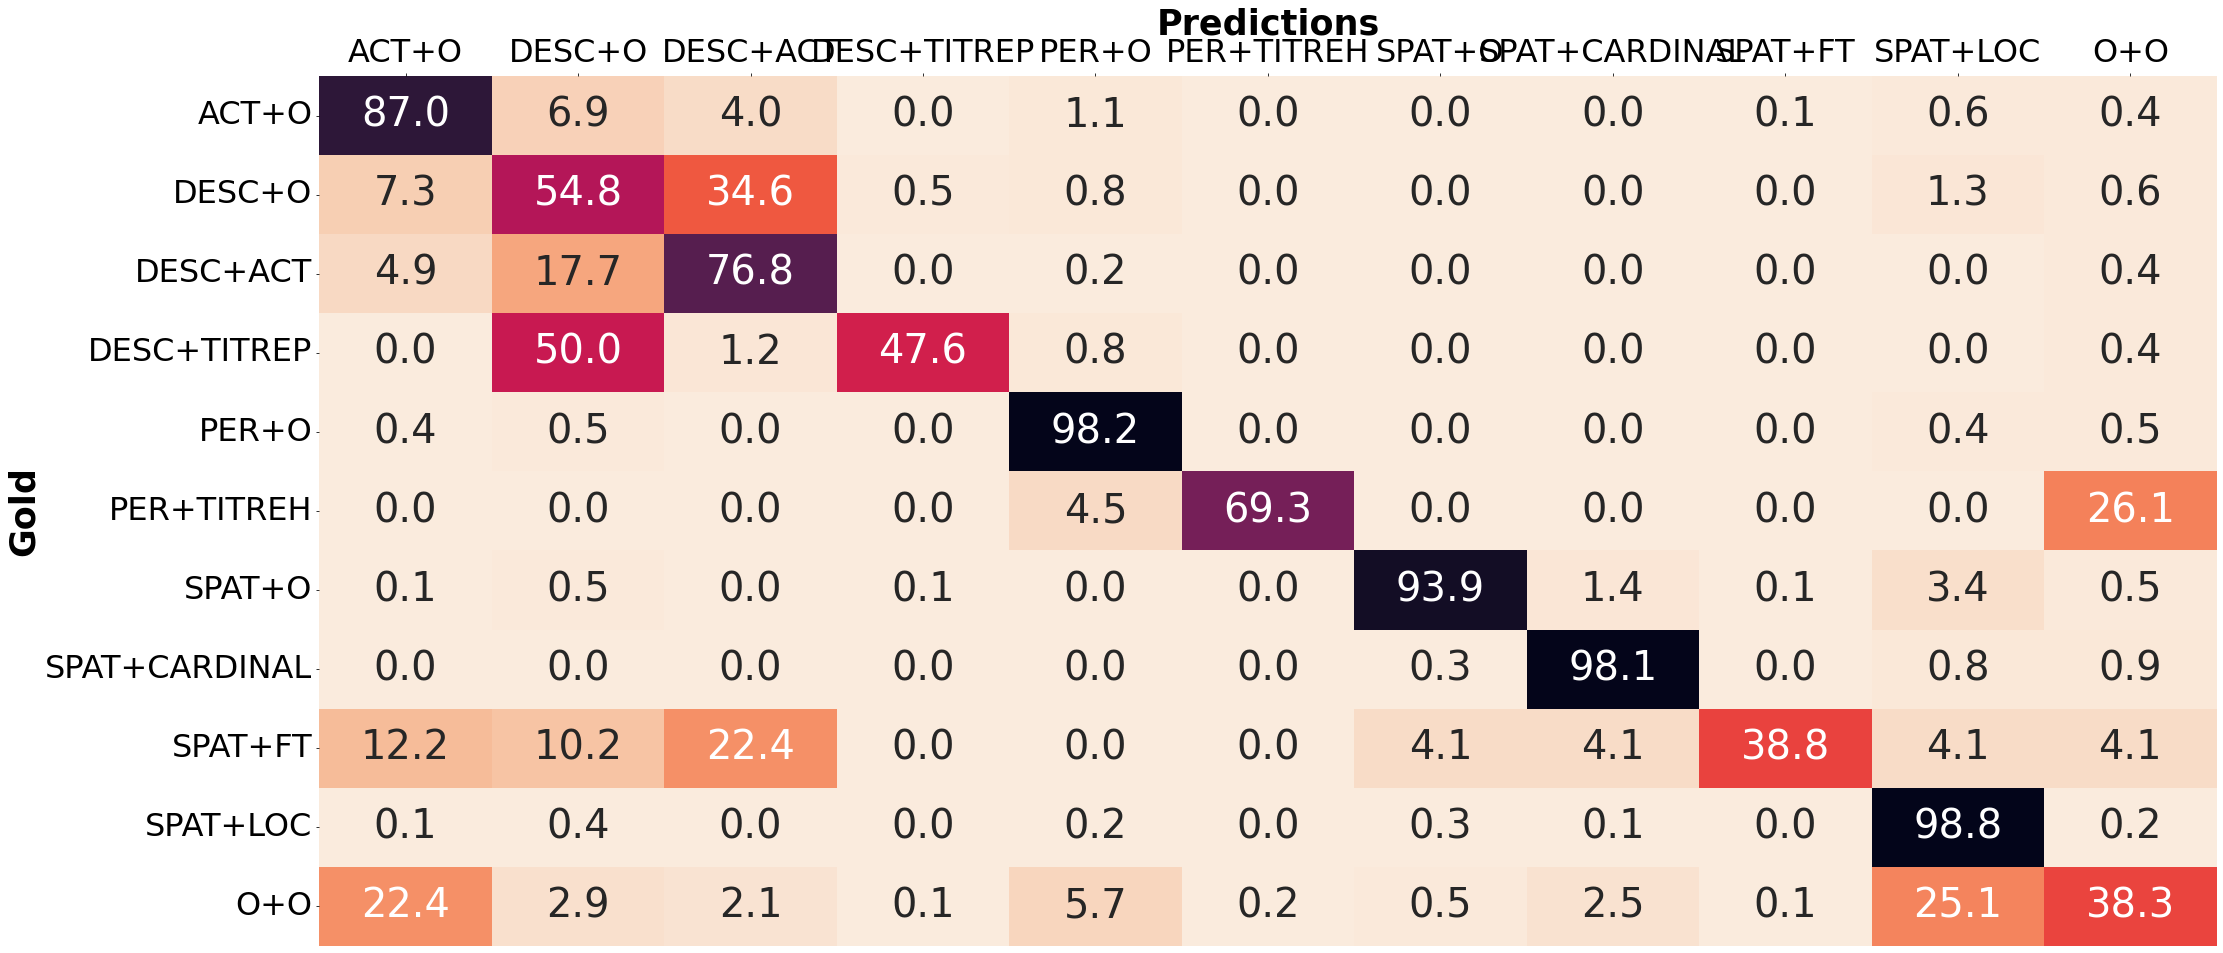

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Init figure
plt.figure(figsize=(34, 16))

#Create heatmap
snsfig = sns.heatmap(
    global_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt=".1f",
    cbar=False,
    annot_kws={"fontsize":40}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=35) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=35) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 32)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 32)

print("Confusion matrix of reference and predicted tokens types.")
print("Values are normalized by row (percentage of each reference classe and its resultants predictions)")
print("Last row represent percentage of each class in gold.")

plt.show()

#Save figure
fig = snsfig.get_figure()
fig.tight_layout()
fig.savefig(f"./tokenscaleanalysis-{FORMAT}-{SET}.pdf") 

## Entry scale analysis

Please choose one entry giving its index to perform an entry scale analysis :

In [61]:
i = 15

In [62]:
print(df.iloc[i]["entry"])
print(df.iloc[i]["entry_xml"])

R H.  Horang cadel 25. Ghenet   du GFos- E &quot;
<SPAT><LOC>R H.  Horang cadel</LOC><CARDINAL> 25</CARDINAL><LOC>. Ghenet   du GFos- E</LOC><CARDINAL> &amp;</CARDINAL></SPAT>quot;


In [63]:
from seqeval.metrics import classification_report

y_preds = df.iloc[i]["tags_preds"]
y_true = df.iloc[i]["tags_gold"]
print(classification_report([y_true],[y_preds]))

                 precision    recall  f1-score   support

          PER+O       0.00      0.00      0.00         1
SPAT+i_CARDINAL       0.00      0.00      0.00         1
     SPAT+i_LOC       0.00      0.00      0.00         1

      micro avg       0.00      0.00      0.00         3
      macro avg       0.00      0.00      0.00         3
   weighted avg       0.00      0.00      0.00         3



/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/lrde/home2/stual/.venv/python_3_9/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_true = pd.Series(df["tags_gold"].iloc[i], name='Gold')
y_pred = pd.Series(df["tags_preds"].iloc[i], name='Predictions')
entry_confusion = pd.crosstab(y_true, y_pred)
entry_confusion

Predictions,I-SPAT+i_CARDINAL,I-SPAT+i_LOC,O+O
Gold,,,
I-PER+O,1,9,0
I-SPAT+i_CARDINAL,1,0,2
I-SPAT+i_LOC,0,6,0
O+O,0,2,0


Confusion matrix of reference and predicted tokens types.


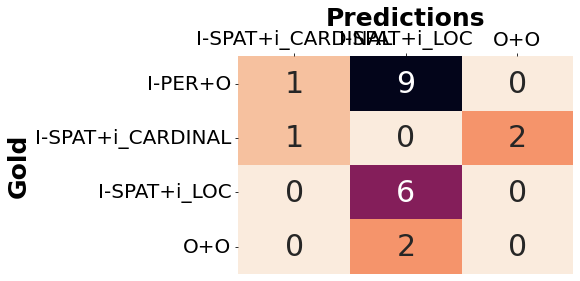

In [65]:
#Create heatmap
snsfig = sns.heatmap(
    entry_confusion, 
    annot = True, #Display labels
    cmap=sns.color_palette("rocket_r", as_cmap=True), #Color
    fmt="g",
    cbar=False,
    annot_kws={"fontsize":30}
)

#Rename label axis and set their style
plt.xlabel('Predictions',weight = 'bold',fontsize=25) # x-axis label with fontsize 15
plt.ylabel('Gold',weight = 'bold',fontsize=25) # y-axis label with fontsize 15

#Set x labels position to top
snsfig.xaxis.tick_top()
snsfig.xaxis.set_label_position('top')

#Rotate y ticks horizontaly
plt.yticks(rotation=0) 

#Change ticks size
snsfig.set_xticklabels(snsfig.get_xmajorticklabels(), fontsize = 20)
snsfig.set_yticklabels(snsfig.get_ymajorticklabels(), fontsize = 20)

print("Confusion matrix of reference and predicted tokens types.")

plt.show()

#Save figure
fig = snsfig.get_figure()